In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from openvino.runtime import Core

In [ ]:
!pip install openvino
!pip install ultralytics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 24.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 530.2/530.2 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.5/199.5 kB 19.4 MB/s eta 0:00:00


In [ ]:
ie = Core()

model = ie.read_model(model="model/horizontal-text-detection-0001.xml")
compiled_model = ie.compile_model(model=model)

input_layer_ir = compiled_model.input(0)
output_layer_ir = compiled_model.output("boxes")

In [ ]:
from typing import Tuple, Dict
import cv2
import numpy as np
from PIL import Image
import random
from ultralytics.yolo.utils.plotting import colors
import matplotlib.pyplot as plt

In [ ]:
def plot_one_box(box:np.ndarray, img:np.ndarray, color:Tuple[int, int, int] = None, mask:np.ndarray = None, label:str = None, line_thickness:int = 5):
    # Plots one bounding box on image img
    tl = line_thickness or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1  # line/font thickness
    color = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(box[0]), int(box[1])), (int(box[2]), int(box[3]))
    cv2.rectangle(img, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    if label:
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(img, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(img, label, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)
    if mask is not None:
        image_with_mask = img.copy()
        mask
        cv2.fillPoly(image_with_mask, pts=[mask.astype(int)], color=color)
        img = cv2.addWeighted(img, 0.5, image_with_mask, 0.5, 1)
    return img

def draw_results(results:Dict, source_image:np.ndarray, label_map:Dict):
    boxes = results["det"]
    masks = results.get("segment")
    h, w = source_image.shape[:2]
    for idx, (*xyxy, conf, lbl) in enumerate(boxes):
        label = f'{label_map[int(lbl)]} {conf:.2f}'
        mask = masks[idx] if masks is not None else None
        source_image = plot_one_box(xyxy, source_image, mask=mask, label=label, color=colors(int(lbl)), line_thickness=1)
    return source_image

In [ ]:
IMAGE_PATH = "output.jpg"

100%|██████████| 6.23M/6.23M [00:00<00:00, 23.4MB/s]

image 1/1 /content/output.jpg: 384x640 1 bowl, 1 laptop, 1 vase, 355.5ms
Speed: 2.9ms preprocess, 355.5ms inference, 28.6ms postprocess per image at shape (1, 3, 640, 640)


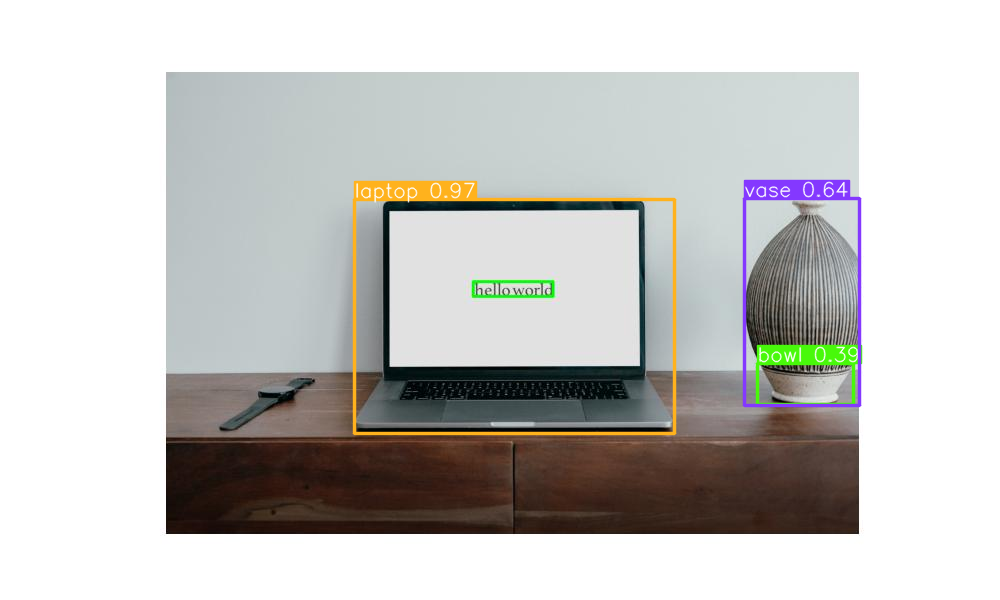

In [ ]:
from ultralytics import YOLO

DET_MODEL_NAME = "yolov8n"

det_model = YOLO(f'{DET_MODEL_NAME}.pt')
label_map = det_model.model.names

res = det_model(IMAGE_PATH)
Image.fromarray(res[0].plot()[:, :, ::-1])

In [ ]:
arr = Image.fromarray(res[0].plot()[:, :, ::-1])

In [ ]:
N, C, H, W = input_layer_ir.shape

In [ ]:
arr.save("detect.png")

In [ ]:
image = cv2.imread(IMAGE_PATH)

In [ ]:
resized_image = cv2.resize(image, (W, H))

In [ ]:
input_image = np.expand_dims(resized_image.transpose(2, 0, 1), 0)
input_image.shape

(1, 3, 704, 704)

In [ ]:
# Create an inference request.
boxes = compiled_model([input_image])[output_layer_ir]

# Remove zero only boxes.
boxes = boxes[~np.all(boxes == 0, axis=1)]

In [ ]:
def convert_result_to_image(bgr_image, resized_image, boxes, threshold=0.3, conf_labels=True):
    colors = {"red": (255, 0, 0), "green": (0, 255, 0)}
    (real_y, real_x), (resized_y, resized_x) = bgr_image.shape[:2], resized_image.shape[:2]
    ratio_x, ratio_y = real_x / resized_x, real_y / resized_y
    rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
    for box in boxes:
        conf = box[-1]
        if conf > threshold:
            (x_min, y_min, x_max, y_max) = [
                int(max(corner_position * ratio_y, 10)) if idx % 2
                else int(corner_position * ratio_x)
                for idx, corner_position in enumerate(box[:-1])
            ]

            # Draw a box based on the position, parameters in rectangle function are: image, start_point, end_point, color, thickness.
            rgb_image = cv2.rectangle(rgb_image, (x_min, y_min), (x_max, y_max), colors["green"], 15)

            # Add text to the image based on position and confidence.
            # Parameters in text function are: image, text, bottom-left_corner_textfield, font, font_scale, color, thickness, line_type.
            if conf_labels:
                rgb_image = cv2.putText(
                    rgb_image,
                    f"{conf:.2f}",
                    (x_min, y_min - 10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.8,
                    colors["red"],
                    1,
                    cv2.LINE_AA,
                )

    return rgb_image

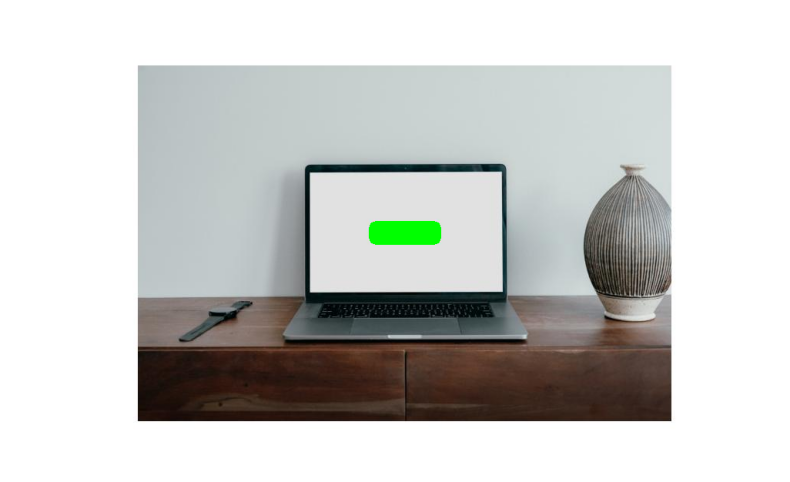

In [ ]:
plt.figure(figsize=(10, 6))
plt.axis("off")
plt.imshow(convert_result_to_image(image, resized_image, boxes, conf_labels=False));
plt.savefig("output.jpg")

In [ ]:
from pathlib import Path

# object detection model
det_model_path = Path(f"{DET_MODEL_NAME}_openvino_model/{DET_MODEL_NAME}.xml")
if not det_model_path.exists():
    det_model.export(format="openvino", dynamic=True, half=False)

Ultralytics YOLOv8.0.87 🚀 Python-3.9.16 torch-2.0.0+cu118 CPU

PyTorch: starting from yolov8n.pt with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 84, 8400) (6.2 MB)
requirements: YOLOv8 requirement "onnx>=1.12.0" not found, attempting AutoUpdate...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 133.4 MB/s eta 0:00:00

requirements: 1 package updated per ['onnx>=1.12.0']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.13.1 opset 17...
ONNX: export success ✅ 9.8s, saved as yolov8n.onnx (12.1 MB)
requirements: YOLOv8 requirement "openvino-dev>=2022.3" not found, attempting AutoUpdate...


============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 67.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 70.6 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 106.5 MB/s eta 0:00:00
  Created wheel for jstyleson: filename=jstyleson-0.0.2-py3-none-any.whl size=2398 sha256=1a30e770c41a9cda5f06c75f69b5f6e822890453eba84dbce443645df875d9d6
  Stored in directory: /tmp/pip-ephem-wheel-cache-f68hdy47/wheels/d4/2a/06/11202ea86be0f51f34e9411d691e25b991d188d93ab4d3e551
Successfully built jstyleson
  Attempting uninstall: networkx
    Found existing installation: networkx 3.1
    Uninstalling networkx-3.1:
      Successfully uninstalled networkx-3.1
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling p

In [ ]:
from typing import Tuple
from ultralytics.yolo.utils import ops
import torch
import numpy as np


def letterbox(img: np.ndarray, new_shape:Tuple[int, int] = (640, 640), color:Tuple[int, int, int] = (114, 114, 114), auto:bool = False, scale_fill:bool = False, scaleup:bool = False, stride:int = 32):
    """
    Resize image and padding for detection. Takes image as input,
    resizes image to fit into new shape with saving original aspect ratio and pads it to meet stride-multiple constraints

    Parameters:
      img (np.ndarray): image for preprocessing
      new_shape (Tuple(int, int)): image size after preprocessing in format [height, width]
      color (Tuple(int, int, int)): color for filling padded area
      auto (bool): use dynamic input size, only padding for stride constrins applied
      scale_fill (bool): scale image to fill new_shape
      scaleup (bool): allow scale image if it is lower then desired input size, can affect model accuracy
      stride (int): input padding stride
    Returns:
      img (np.ndarray): image after preprocessing
      ratio (Tuple(float, float)): hight and width scaling ratio
      padding_size (Tuple(int, int)): height and width padding size


    """
    # Resize and pad image while meeting stride-multiple constraints
    shape = img.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better test mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scale_fill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return img, ratio, (dw, dh)


def preprocess_image(img0: np.ndarray):
    """
    Preprocess image according to YOLOv8 input requirements.
    Takes image in np.array format, resizes it to specific size using letterbox resize and changes data layout from HWC to CHW.

    Parameters:
      img0 (np.ndarray): image for preprocessing
    Returns:
      img (np.ndarray): image after preprocessing
    """
    # resize
    img = letterbox(img0)[0]

    # Convert HWC to CHW
    img = img.transpose(2, 0, 1)
    img = np.ascontiguousarray(img)
    return img


def image_to_tensor(image:np.ndarray):
    """
    Preprocess image according to YOLOv8 input requirements.
    Takes image in np.array format, resizes it to specific size using letterbox resize and changes data layout from HWC to CHW.

    Parameters:
      img (np.ndarray): image for preprocessing
    Returns:
      input_tensor (np.ndarray): input tensor in NCHW format with float32 values in [0, 1] range
    """
    input_tensor = image.astype(np.float32)  # uint8 to fp32
    input_tensor /= 255.0  # 0 - 255 to 0.0 - 1.0

    # add batch dimension
    if input_tensor.ndim == 3:
        input_tensor = np.expand_dims(input_tensor, 0)
    return input_tensor

In [ ]:
def postprocess(
    pred_boxes:np.ndarray,
    input_hw:Tuple[int, int],
    orig_img:np.ndarray,
    min_conf_threshold:float = 0.25,
    nms_iou_threshold:float = 0.7,
    agnosting_nms:bool = False,
    max_detections:int = 300,
    pred_masks:np.ndarray = None,
    retina_mask:bool = False
):
    """
    YOLOv8 model postprocessing function. Applied non maximum supression algorithm to detections and rescale boxes to original image size
    Parameters:
        pred_boxes (np.ndarray): model output prediction boxes
        input_hw (np.ndarray): preprocessed image
        orig_image (np.ndarray): image before preprocessing
        min_conf_threshold (float, *optional*, 0.25): minimal accepted confidence for object filtering
        nms_iou_threshold (float, *optional*, 0.45): minimal overlap score for removing objects duplicates in NMS
        agnostic_nms (bool, *optiona*, False): apply class agnostinc NMS approach or not
        max_detections (int, *optional*, 300):  maximum detections after NMS
        pred_masks (np.ndarray, *optional*, None): model ooutput prediction masks, if not provided only boxes will be postprocessed
        retina_mask (bool, *optional*, False): retina mask postprocessing instead of native decoding
    Returns:
       pred (List[Dict[str, np.ndarray]]): list of dictionary with det - detected boxes in format [x1, y1, x2, y2, score, label] and segment - segmentation polygons for each element in batch
    """
    nms_kwargs = {"agnostic": agnosting_nms, "max_det":max_detections}
    # if pred_masks is not None:
    #     nms_kwargs["nm"] = 32
    preds = ops.non_max_suppression(
        torch.from_numpy(pred_boxes),
        min_conf_threshold,
        nms_iou_threshold,
        nc=80,
        **nms_kwargs
    )
    results = []
    proto = torch.from_numpy(pred_masks) if pred_masks is not None else None

    for i, pred in enumerate(preds):
        shape = orig_img[i].shape if isinstance(orig_img, list) else orig_img.shape
        if not len(pred):
            results.append({"det": [], "segment": []})
            continue
        if proto is None:
            pred[:, :4] = ops.scale_boxes(input_hw, pred[:, :4], shape).round()
            results.append({"det": pred})
            continue
        if retina_mask:
            pred[:, :4] = ops.scale_boxes(input_hw, pred[:, :4], shape).round()
            masks = ops.process_mask_native(proto[i], pred[:, 6:], pred[:, :4], shape[:2])  # HWC
            segments = [ops.scale_segments(input_hw, x, shape, normalize=False) for x in ops.masks2segments(masks)]
        else:
            masks = ops.process_mask(proto[i], pred[:, 6:], pred[:, :4], input_hw, upsample=True)
            pred[:, :4] = ops.scale_boxes(input_hw, pred[:, :4], shape).round()
            segments = [ops.scale_segments(input_hw, x, shape, normalize=False) for x in ops.masks2segments(masks)]
        results.append({"det": pred[:, :6].numpy(), "segment": segments})
    return results

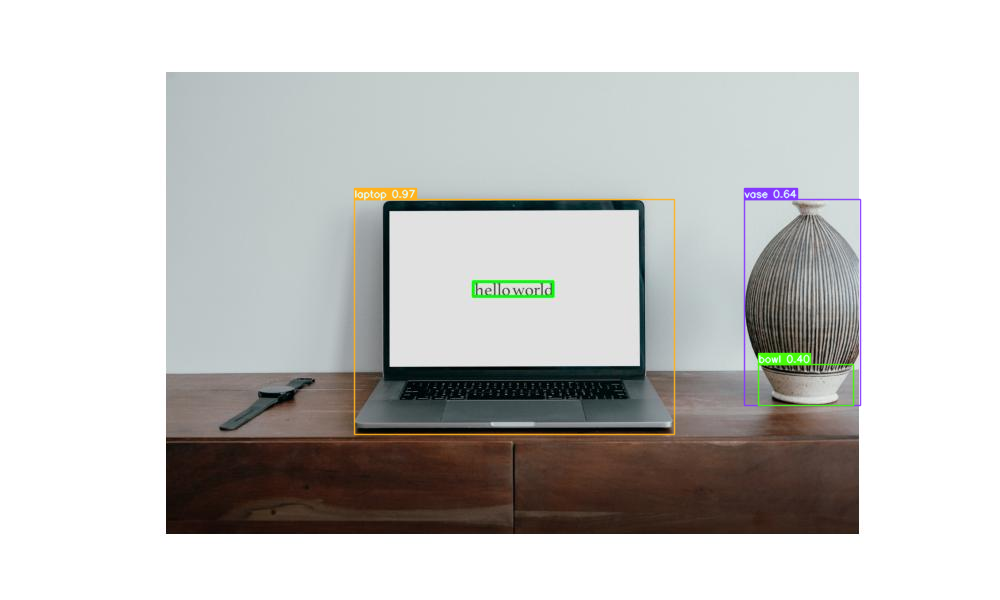

In [ ]:
from openvino.runtime import Core, Model

core = Core()
det_ov_model = core.read_model(det_model_path)
device = "CPU"  # "GPU"
if device != "CPU":
    det_ov_model.reshape({0: [1, 3, 640, 640]})
det_compiled_model = core.compile_model(det_ov_model, device)


def detect(image:np.ndarray, model:Model):
    """
    OpenVINO YOLOv8 model inference function. Preprocess image, runs model inference and postprocess results using NMS.
    Parameters:
        image (np.ndarray): input image.
        model (Model): OpenVINO compiled model.
    Returns:
        detections (np.ndarray): detected boxes in format [x1, y1, x2, y2, score, label]
    """
    num_outputs = len(model.outputs)
    preprocessed_image = preprocess_image(image)
    input_tensor = image_to_tensor(preprocessed_image)
    result = model(input_tensor)
    boxes = result[model.output(0)]
    masks = None
    if num_outputs > 1:
        masks = result[model.output(1)]
    input_hw = input_tensor.shape[2:]
    detections = postprocess(pred_boxes=boxes, input_hw=input_hw, orig_img=image, pred_masks=masks)
    return detections


input_image = np.array(Image.open(IMAGE_PATH))
detections = detect(input_image, det_compiled_model)[0]
image_with_boxes = draw_results(detections, input_image, label_map)

Image.fromarray(image_with_boxes)

In [ ]:
!benchmark_app -m $det_model_path -d $device -api async -shape "[1,3,640,640]"

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2022.3.0-9052-9752fafe8eb-releases/2022/3
[ INFO ] 
[ INFO ] Device info:
[ INFO ] CPU
[ INFO ] Build ................................. 2022.3.0-9052-9752fafe8eb-releases/2022/3
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(CPU) performance hint will be set to THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 95.24 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     images (node: images) : f32 / [...] / [?,3,?,?]
[ INFO ] Model outputs:
[ INFO ]     output0 (node: output0) : f32 / [...] / [?,84,?]
[Step 5/11] Resizing model to match image sizes and given batch
[ INFO ] Model batch size: 1
[ INFO ] Reshaping model: 'images': [1,3,6